# Provided dataset description

We collected EEG signal data from 10 college students while they watched MOOC video clips. We extracted online education videos that are assumed not to be confusing for college students, such as videos of the introduction of basic algebra or geometry. We also prepare videos that are expected to confuse a typical college student if a student is not familiar with the video topics like Quantum Mechanics, and Stem Cell Research. We prepared 20 videos, 10 in each category. Each video was about 2 minutes long. We chopped the two-minute clip in the middle of a topic to make the videos more confusing.
The students wore a single-channel wireless MindSet that measured activity over the frontal lobe. The MindSet measures the voltage between an electrode resting on the forehead and two electrodes (one ground and one reference) each in contact with an ear.
After each session, the student rated his/her confusion level on a scale of 1-7, where one corresponded to the least confusing and seven corresponded to the most confusing. These labels if further normalized into labels of whether the students are confused or not. This label is offered as self-labelled confusion in addition to our predefined label of confusion.

Content
These data are collected from ten students, each watching ten videos. Therefore, it can be seen as only 100 data points for these 12000+ rows. If you look at this way, then each data point consists of 120+ rows, which is sampled every 0.5 seconds (so each data point is a one minute video). Signals with higher frequency are reported as the mean value during each 0.5 second.

EEG_data.csv: Contains the EEG data recorded from 10 students

https://www.kaggle.com/datasets/wanghaohan/confused-eeg/data?select=EEG_data.csv



BRAINWAVE BANDS

1 - Delta (0.5-4 Hz): Associated with deep, dreamless sleep, unconsciousness, and physical restoration.

2- Theta (4-8 Hz): Linked to deep relaxation, meditation, creativity, introspection, and light sleep (especially REM).

3 - Alpha (8-12 Hz): Characteristic of relaxed wakefulness, a calm and reflective state, and mental peace.

4 - Beta (13-30 Hz): Dominant during active thinking, alertness, concentration, problem-solving, and engaged mental activity.

5 - Gamma (30-100+ Hz): Involved in high-level information processing, intense focus, learning, memory formation, and heightened perception.


# Import Libraries

In [1]:
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, recall_score, precision_score

In [2]:
# LSTM Imports
import keras
import os

PYTHONHASHSEED = 0

from sklearn import preprocessing

from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

# Load and evaluate data
missing values

datatypes

value counts

description of each column type

In [3]:
raw_df = pd.read_csv('EEG_data_confused.csv')
raw_df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
dtypes: float64(15)
memory usage: 1.5 MB


In [5]:
raw_df.describe()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
count,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000
mean,4.487394,4.390602,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.479978,0.512606
std,2.865373,2.913232,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499618,0.499861
min,0.000000,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000
25%,2.000000,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000,0.000000
50%,4.000000,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,0.000000,1.000000
75%,7.000000,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000,1.000000
max,9.000000,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000


In [6]:
raw_df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [7]:
# Rows, columns
raw_df.shape 

(12811, 15)

In [8]:
# Show col datatypes in df
raw_df.dtypes

SubjectID             float64
VideoID               float64
Attention             float64
Mediation             float64
Raw                   float64
Delta                 float64
Theta                 float64
Alpha1                float64
Alpha2                float64
Beta1                 float64
Beta2                 float64
Gamma1                float64
Gamma2                float64
predefinedlabel       float64
user-definedlabeln    float64
dtype: object

In [9]:
# Total missing values in df
raw_df.isnull().sum().sum()

0

In [10]:
# Count duplicate rows
raw_df.duplicated().sum()

0

In [11]:
# Count target labels
raw_df['user-definedlabeln'].value_counts()

user-definedlabeln
1.0    6567
0.0    6244
Name: count, dtype: int64

In [12]:
# Count SubjectID
raw_df['SubjectID'].nunique()

10

 NeuroSky MindSet (and related headsets like the MindWave/MindWave Mobile) sample raw EEG at 512 Hz, using a 12-bit resolution ADC, and capture brainwave data in the 3–100 Hz range 
<br>store.neurosky.com


# Add seconds, min elapsed

In [13]:
# Add time_elapsed column in seconds based on 512 Hz sampling rate for MindSet EEG
raw_df['seconds_elapsed'] = raw_df.index / 512
# Add seconds and minute elapsed columns
raw_df['minutes_elapsed'] = raw_df['seconds_elapsed'] // 60

raw_df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,seconds_elapsed,minutes_elapsed
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,0.001953,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,0.003906,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,0.005859,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,0.007812,0.0


# Define x and y for training

In [14]:
# Variables
X = raw_df.drop(['user-definedlabeln', 'seconds_elapsed', 'minutes_elapsed'], axis=1) # axis 1 = across columns
y =raw_df['user-definedlabeln']

# Visualize slice of fft vs time vs label

showing 3 groups of PSD data for when the label is negative, positive and neutral

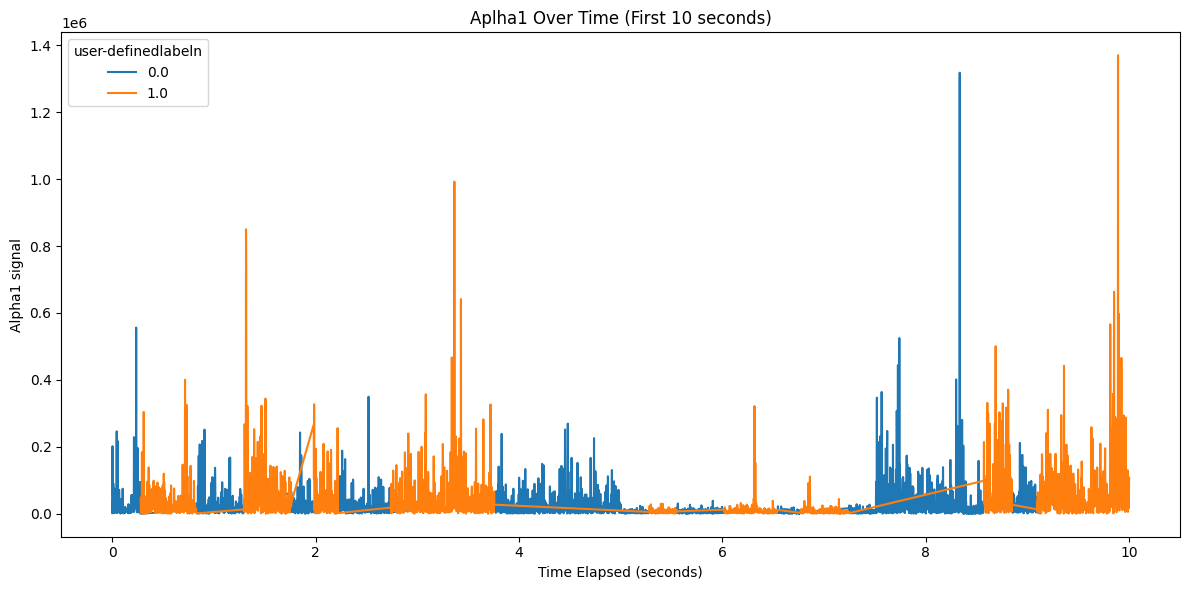

In [15]:
# Select a reasonable slice of time, e.g., first 10 seconds
slice_df = raw_df[raw_df['seconds_elapsed'] <= 10]

# Plot time vs fft, color-coded by label
plt.figure(figsize=(12, 6))
sns.lineplot(data=slice_df, x='seconds_elapsed', y='Alpha1', hue='user-definedlabeln')
plt.title('Aplha1 Over Time (First 10 seconds)')
plt.xlabel('Time Elapsed (seconds)')
plt.ylabel('Alpha1 signal')
plt.legend(title='user-definedlabeln')
plt.tight_layout()
plt.show()

interpretation:

confused label is when alpha1 is  *************
non confused label is when alpha1 is ********

# Denoising brainwave columns
Plot 0.5 second binned avg PSD values

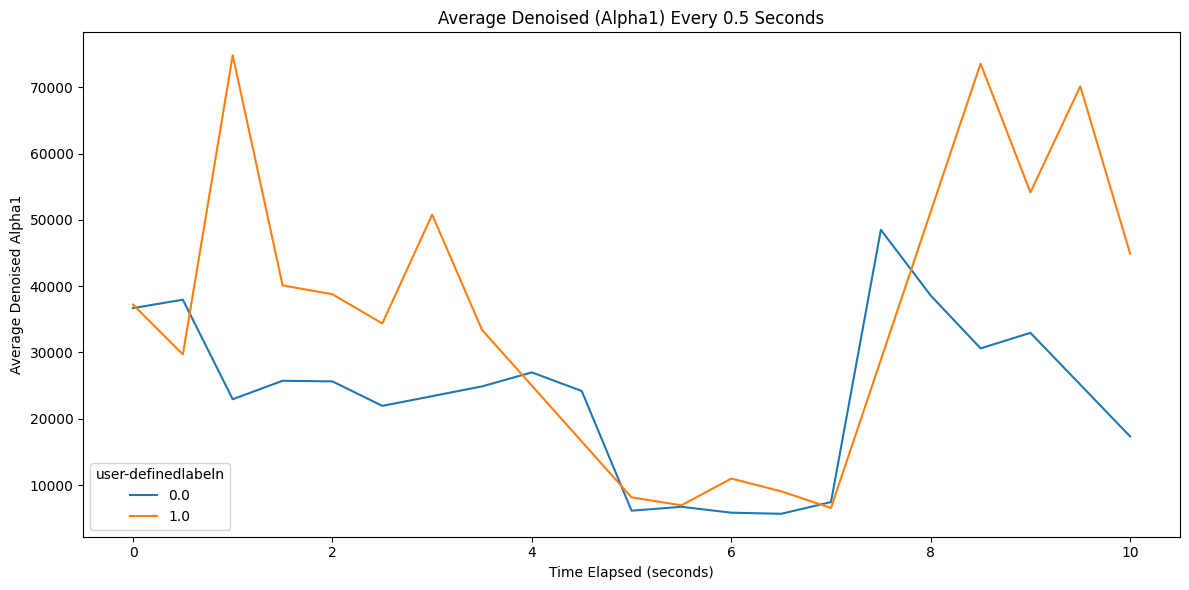

In [16]:
# Create a copy to hold binned data
bin_df = raw_df.copy()

# Create 0.5 second bins
bin_df['time_bin'] = (bin_df['seconds_elapsed'] // 0.5) * 0.5

# Define brainwave columns
brainwave_cols = ['Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']

# Group by time_bin and label, average all brainwave columns
avg_df = bin_df.groupby(['time_bin', 'user-definedlabeln'], as_index=False)[brainwave_cols].mean()

# Slice for plotting (first 10 seconds only)
slice_df = avg_df[avg_df['time_bin'] <= 10]

# Plot only Alpha1
plt.figure(figsize=(12, 6))
sns.lineplot(data=slice_df, x='time_bin', y='Alpha1', hue='user-definedlabeln')
plt.title('Average Denoised (Alpha1) Every 0.5 Seconds')
plt.xlabel('Time Elapsed (seconds)')
plt.ylabel('Average Denoised Alpha1')
plt.legend(title='user-definedlabeln')
plt.tight_layout()
plt.show()


# XGBoost Training - no denoising

In [17]:
# Split data into training and validation sets for early stopping (binary classification)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- XGBoost Model Training with Early Stopping (Binary Class) ---

print("--- Starting XGBoost Training with Early Stopping (Binary Class) ---")

model = xgb.XGBClassifier(
    n_estimators=1000,
    objective="binary:logistic",  # Use binary:logistic for binary classification
    eval_metric="logloss",        # Use logloss for binary classification
    random_state=42,
    early_stopping_rounds=50,
)

# Fit the model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=20
)

print("\n--- XGBoost Training Completed ---")

# --- 4. Access Best Iteration and Score ---
print(f"Best iteration (number of trees): {model.best_iteration}")
print(f"Best validation score: {model.best_score}")


--- Starting XGBoost Training with Early Stopping (Binary Class) ---
[0]	validation_0-logloss:0.56751
[20]	validation_0-logloss:0.18542
[40]	validation_0-logloss:0.03447
[60]	validation_0-logloss:0.01718
[80]	validation_0-logloss:0.00820
[100]	validation_0-logloss:0.00591
[120]	validation_0-logloss:0.00479
[140]	validation_0-logloss:0.00374
[160]	validation_0-logloss:0.00308
[180]	validation_0-logloss:0.00268
[200]	validation_0-logloss:0.00249
[220]	validation_0-logloss:0.00234
[240]	validation_0-logloss:0.00226
[260]	validation_0-logloss:0.00218
[280]	validation_0-logloss:0.00205
[300]	validation_0-logloss:0.00194
[320]	validation_0-logloss:0.00186
[340]	validation_0-logloss:0.00183
[360]	validation_0-logloss:0.00178
[380]	validation_0-logloss:0.00175
[400]	validation_0-logloss:0.00172
[420]	validation_0-logloss:0.00171
[440]	validation_0-logloss:0.00170
[460]	validation_0-logloss:0.00169
[480]	validation_0-logloss:0.00170
[500]	validation_0-logloss:0.00169
[520]	validation_0-logloss:

In [18]:
# Predict class probabilities
y_val_proba = model.predict_proba(X_val)

# Predict class labels
y_val_pred = model.predict(X_val)

# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Log loss (multi-class logloss, same as eval_metric)
val_logloss = log_loss(y_val, y_val_proba)
print(f"Validation Log Loss: {val_logloss:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print(cm)

# Detailed classification report (precision, recall, f1-score)
report = classification_report(y_val, y_val_pred, target_names=[str(cls) for cls in model.classes_])
print("\nClassification Report:")
print(report)


Validation Accuracy: 1.0000
Validation Log Loss: 0.0016

Confusion Matrix:
[[1249    0]
 [   0 1314]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1249
           1       1.00      1.00      1.00      1314

    accuracy                           1.00      2563
   macro avg       1.00      1.00      1.00      2563
weighted avg       1.00      1.00      1.00      2563



# Shap value for feature correlation (top 50 per label) - no denoising

In [ ]:
# Explain the model with SHAP
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# SHAP values for each class
for class_idx in range(2):  # Loop over classes
    class_shap_values = shap_values.values[:, :, class_idx]

    mean_abs_shap = np.abs(class_shap_values).mean(axis=0)
    n_top_features = min(50, class_shap_values.shape[1])
    top_50_idx = np.argsort(mean_abs_shap)[-n_top_features:][::-1]

    X_top50_shap = class_shap_values[:, top_50_idx]
    X_top50_data = X.iloc[:, top_50_idx].values
    top_50_names = np.array(X.columns)[top_50_idx]

    plt.figure(figsize=(10, 6))

    shap.summary_plot(
        X_top50_shap,
        X_top50_data,
        feature_names=top_50_names,
        max_display=50,
        show=False
    )

    plt.title(f"Top 50 SHAP features for class {class_idx}")
    plt.show()

 27%|=====               | 3463/12811 [02:14<06:01]       

# XGBoost Training and Shap value for feature correlation (top 50) - with denoising

In [ ]:
avg_df.head()

In [ ]:
# Variables
X = avg_df.drop(['user-definedlabeln', 'time_bin'], axis=1) # axis 1 = across columns
y = avg_df['user-definedlabeln']
# Encode y values to numeric**************************************
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
# Split data into training and validation sets for early stopping
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)


# ---  XGBoost Model Training with Early Stopping (MODIFIED FOR 3 CLASSES) ---

print("--- Starting XGBoost Training with Early Stopping (3 Classes) ---")

model = xgb.XGBClassifier(
    n_estimators=1000,
    # --- MODIFICATION FOR MULTI-CLASS ---
    objective="multi:softprob", # Use "multi:softprob" for probability output for each class
    eval_metric="mlogloss",     # "mlogloss" (multi-class logloss) for evaluation
    num_class=3,                # Number of unique classes in target
    random_state=42,
    early_stopping_rounds=50,
)

# Fit the model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=20
)

print("\n--- XGBoost Training Completed ---")

# --- 4. Access Best Iteration and Score ---
print(f"Best iteration (number of trees): {model.best_iteration}")
print(f"Best validation score: {model.best_score}")

In [ ]:
# Predict class probabilities
y_val_proba = model.predict_proba(X_val)

# Predict class labels
y_val_pred = model.predict(X_val)

# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Log loss (multi-class logloss, same as eval_metric)
val_logloss = log_loss(y_val, y_val_proba)
print(f"Validation Log Loss: {val_logloss:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print(cm)

# Detailed classification report (precision, recall, f1-score)
report = classification_report(y_val, y_val_pred, target_names=le.classes_)
print("\nClassification Report:")
print(report)

In [ ]:
# Explain the model with SHAP
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# SHAP values for each class
for class_idx in range(3):  # Loop over classes 0,1,2
    class_shap_values = shap_values.values[:, :, class_idx]

    mean_abs_shap = np.abs(class_shap_values).mean(axis=0)
    n_top_features = min(50, class_shap_values.shape[1])
    top_50_idx = np.argsort(mean_abs_shap)[-n_top_features:][::-1]

    X_top50_shap = class_shap_values[:, top_50_idx]
    X_top50_data = X.iloc[:, top_50_idx].values
    top_50_names = np.array(X.columns)[top_50_idx]

    plt.figure(figsize=(10, 6))

    shap.summary_plot(
        X_top50_shap,
        X_top50_data,
        feature_names=top_50_names,
        max_display=50,
        show=False
    )

    plt.title(f"Top 50 SHAP features for class {class_idx}")
    plt.show()